*This Notebook has been created by PALISSON Antoine.*<br>


In [ ]:
# Basic packages
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf

# Preprocessing

**<font color='blue'>1. Load the dataset and show its content.**

In [ ]:
df = pd.read_csv('/content/bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


**<font color='blue'>2. Separate the features and the label (the `deposit` variable).**

In [ ]:
X = df.copy()
y = X.pop('deposit').to_numpy()

**<font color='blue'>3. Create a test and validation set.**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/(1-0.1), random_state=42)

**<font color='blue'>4. Preprocess the data.**

*Tips: The preprocessing is different for the numerical and the categorical data*

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CycleScaler(BaseEstimator, TransformerMixin):
    def __init__(self, step):
        self.step = step

    def fit(self, X, y = None):
        self.cat = {key:val for val, key in enumerate(X.unique())}
        return self

    def transform(self, X, y = None):
        sin = pd.Series(np.sin(2 * np.pi * X.map(self.cat)/self.step),
                        name=f'Sinus_{X.name}')
        cos = pd.Series(np.cos(2 * np.pi * X.map(self.cat)/self.step),
                        name=f'Cosinus_{X.name}')
        X_out = pd.concat([sin, cos], axis=1)
        return X_out
        
    def fit_transform(self, X, y = None):
        self.fit(X, y = None)
        return self.transform(X, y = None)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder, 
                                   StandardScaler)

ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
std = StandardScaler()
cyc = CycleScaler(step=12)
lbe = LabelEncoder()

cat_col = X_train.select_dtypes(include='object').drop(columns=['month'], axis=1).columns
cat_col = np.concatenate([cat_col, np.array(['campaign'])], axis=-1)
num_col = X_train.drop(columns=['month']).drop(columns=cat_col).columns
cyc_col = 'month'

ct = ColumnTransformer([('cat', ohe, cat_col),
                        ('month', cyc, cyc_col),
                        ('num', std, num_col)])

X_train_t = ct.fit_transform(X_train)
X_val_t = ct.transform(X_val)
X_test_t = ct.transform(X_test)

y_train_t = lbe.fit_transform(y_train)
y_val_t = lbe.transform(y_val)
y_test_t = lbe.transform(y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Benchmark

In this part, you will build a **benchmark** to compare the effect of the vanishing/exploding gradient and overfitting tools.

Here is a small function that should be run before every training to reset the seeds.<br> This ensures that the **randomness is always the same during training**, hence making the results comparable.

In [ ]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

**<font color='blue'>1. Build a model architecture that contains 2 hidden layers with 16 neurons and a ReLU activation.<br> The remaining parameters are set to default.<br> Add the appropriate output layer.**

*Tips: You should run the reset_seeds() function at the beginning of the cell.*

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16, activation='relu')(inputs)

dense_2 = tf.keras.layers.Dense(16, activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

bench_model = tf.keras.Model(inputs=inputs, outputs=outputs)

**<font color='blue'>2. Compile the model with the SGD optimizer and the appropriate loss.**

In [ ]:
# Compiling
bench_model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['Accuracy'])

**<font color='blue'>3. Train the model for 20 epochs with a batch size of 32.**

*Tips: Don't forget the validation data !*

In [ ]:
# Training
epochs = 20
batch_size = 32
bench_history = bench_model.fit(X_train_t, y_train_t,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(X_val_t, y_val_t))

Epoch 1/20
279/279 [==============================] - 1s 3ms/step - loss: 0.6404 - Accuracy: 0.6520 - val_loss: 0.6039 - val_Accuracy: 0.6911
Epoch 2/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5535 - Accuracy: 0.7388 - val_loss: 0.5275 - val_Accuracy: 0.7422
Epoch 3/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4919 - Accuracy: 0.7731 - val_loss: 0.4811 - val_Accuracy: 0.7735
Epoch 4/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4590 - Accuracy: 0.7908 - val_loss: 0.4529 - val_Accuracy: 0.7914
Epoch 5/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4414 - Accuracy: 0.8026 - val_loss: 0.4357 - val_Accuracy: 0.7986
Epoch 6/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4308 - Accuracy: 0.8094 - val_loss: 0.4248 - val_Accuracy: 0.8039
Epoch 7/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4245 - Accuracy: 0.8129 - val_loss: 0.4179 - val_Accuracy: 0.8075
Epoch 

**<font color='blue'>4. Display the loss curves (training & validation).** 

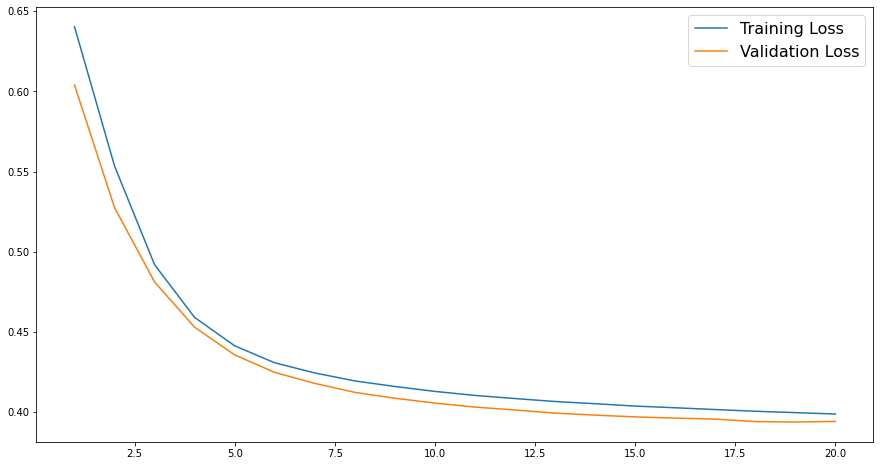

In [ ]:
# Learning Curves
bench_loss = bench_history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), bench_loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), bench_loss['val_loss'], label='Validation Loss')

plt.legend(fontsize=16)
plt.show()

# Vanishing/Explodient gradient tools

## Weight Initialization

**The Tensorflow default initialization method for the dense layers is the Glorot Uniform**.

However, the ReLU activation function works best with the He initialization.<br> It has two main forms: the uniform and the normal ones.

In Tensorflow, you can specify the the weigth initialization, you can use the `kernel_initializer` parameter. <br>The available weigth initialization methods can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/initializers).

**<font color='blue'>Re-build the Benchmarck network with the He initialization for the hidden layers.<br> Train it and compare the results with the benchmark**

Epoch 1/20
279/279 [==============================] - 1s 3ms/step - loss: 0.6746 - Accuracy: 0.5767 - val_loss: 0.6313 - val_Accuracy: 0.6321
Epoch 2/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5997 - Accuracy: 0.6785 - val_loss: 0.5676 - val_Accuracy: 0.7019
Epoch 3/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5443 - Accuracy: 0.7251 - val_loss: 0.5171 - val_Accuracy: 0.7350
Epoch 4/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5034 - Accuracy: 0.7543 - val_loss: 0.4808 - val_Accuracy: 0.7637
Epoch 5/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4749 - Accuracy: 0.7723 - val_loss: 0.4544 - val_Accuracy: 0.7825
Epoch 6/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4545 - Accuracy: 0.7851 - val_loss: 0.4365 - val_Accuracy: 0.8004
Epoch 7/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4418 - Accuracy: 0.7985 - val_loss: 0.4245 - val_Accuracy: 0.7986
Epoch 

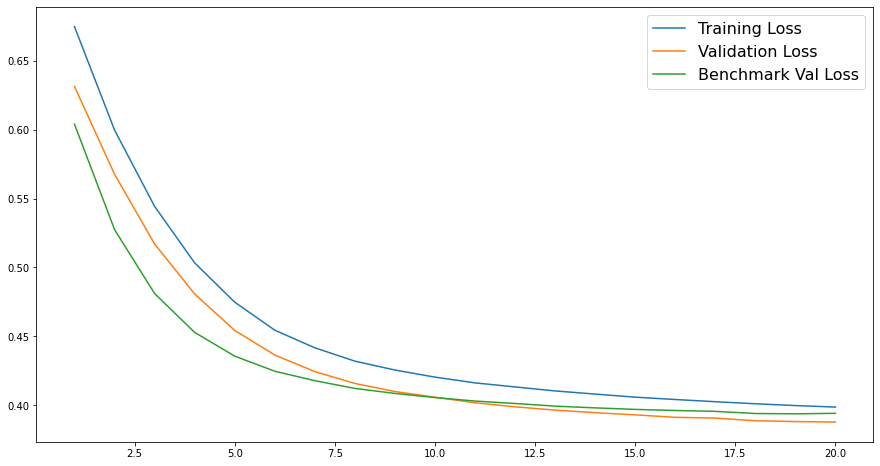

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16,
                                kernel_initializer='he_normal', 
                                activation='relu')(inputs)

dense_2 = tf.keras.layers.Dense(16, 
                                kernel_initializer='he_normal', 
                                activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(1, 
                                activation='sigmoid')(dense_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['Accuracy'])

# Training
epochs = 20
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t))

# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,epochs+1), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

## ReLU variants

The ReLU activation function has many variants that may be useful to alleviate the dying ReLU and vanishing/exploding gradient problems.

The Tensorflow activation functions can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/activations).<br> You can also use the [Activation "layer" tool](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation). 

The Leaky ReLU can only be used as a layer : `tf.keras.layers.LeakyReLU()`.<br>Thus, you must add it after each dense layers which should also have their activation parameters set to None. 

**<font color='blue'>1.a. Re-build the network with the Leaky ReLU (set its alpha parameter to 0.1) for the hidden layers and choose the appropriate weight initilization method.<br>1.b Show the model summary.<br> 1.c.Train it and compare the results with the Benchmark**

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16,
                                kernel_initializer='he_normal', 
                                activation=None)(inputs)

leaky_1 = tf.keras.layers.LeakyReLU(alpha=0.1)(dense_1)

dense_2 = tf.keras.layers.Dense(16, 
                                kernel_initializer='he_normal', 
                                activation=None)(leaky_1)

leaky_2 = tf.keras.layers.LeakyReLU(alpha=0.1)(dense_2)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(leaky_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 16)                624       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 913
Trainable params: 913
Non-trainable params:

Epoch 1/20
279/279 [==============================] - 1s 3ms/step - loss: 0.6735 - Accuracy: 0.5799 - val_loss: 0.6252 - val_Accuracy: 0.6446
Epoch 2/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5954 - Accuracy: 0.6821 - val_loss: 0.5618 - val_Accuracy: 0.7073
Epoch 3/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5418 - Accuracy: 0.7277 - val_loss: 0.5134 - val_Accuracy: 0.7466
Epoch 4/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5030 - Accuracy: 0.7573 - val_loss: 0.4789 - val_Accuracy: 0.7654
Epoch 5/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4761 - Accuracy: 0.7735 - val_loss: 0.4534 - val_Accuracy: 0.7816
Epoch 6/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4568 - Accuracy: 0.7883 - val_loss: 0.4358 - val_Accuracy: 0.7950
Epoch 7/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4445 - Accuracy: 0.7975 - val_loss: 0.4244 - val_Accuracy: 0.8030
Epoch 

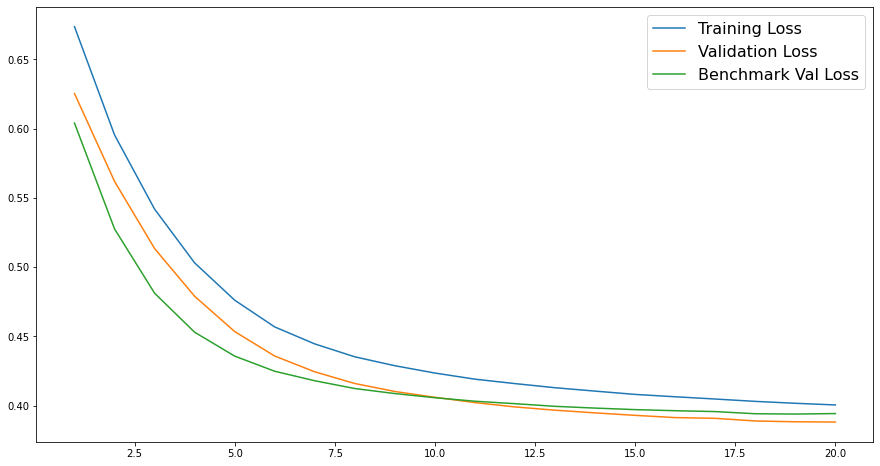

In [ ]:
# Training
epochs = 20
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t))

# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,epochs+1), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

**<font color='blue'>2. Do the same for the ELU activation function.**

*Tips: As opposed to the leaky ReLU, the ELU can be added directly inside the dense layers.*

Epoch 1/20
279/279 [==============================] - 1s 3ms/step - loss: 0.6452 - Accuracy: 0.6230 - val_loss: 0.5658 - val_Accuracy: 0.7010
Epoch 2/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5427 - Accuracy: 0.7256 - val_loss: 0.5044 - val_Accuracy: 0.7547
Epoch 3/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4985 - Accuracy: 0.7608 - val_loss: 0.4674 - val_Accuracy: 0.7798
Epoch 4/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4720 - Accuracy: 0.7807 - val_loss: 0.4447 - val_Accuracy: 0.7968
Epoch 5/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4559 - Accuracy: 0.7941 - val_loss: 0.4308 - val_Accuracy: 0.8030
Epoch 6/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4447 - Accuracy: 0.8011 - val_loss: 0.4215 - val_Accuracy: 0.8057
Epoch 7/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4379 - Accuracy: 0.8079 - val_loss: 0.4164 - val_Accuracy: 0.8030
Epoch 

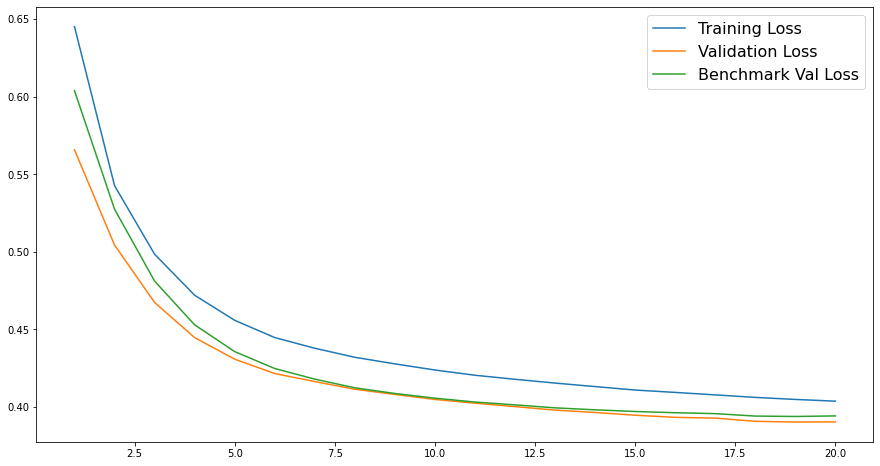

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16,
                                kernel_initializer='he_normal', 
                                activation='elu')(inputs)

dense_2 = tf.keras.layers.Dense(16, 
                                kernel_initializer='he_normal', 
                                activation='elu')(dense_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy'])

# Training
epochs = 20
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t))

# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,epochs+1), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

**<font color='blue'>3. Do the same for the SELU activation function.<br> Comment the results.**

*Tips: What should be the weight initialization method for the SELU ?*

Epoch 1/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5920 - Accuracy: 0.6822 - val_loss: 0.4975 - val_Accuracy: 0.7610
Epoch 2/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4856 - Accuracy: 0.7754 - val_loss: 0.4463 - val_Accuracy: 0.7950
Epoch 3/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4573 - Accuracy: 0.7973 - val_loss: 0.4272 - val_Accuracy: 0.8013
Epoch 4/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4454 - Accuracy: 0.8047 - val_loss: 0.4181 - val_Accuracy: 0.8075
Epoch 5/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4390 - Accuracy: 0.8099 - val_loss: 0.4133 - val_Accuracy: 0.8066
Epoch 6/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4338 - Accuracy: 0.8121 - val_loss: 0.4100 - val_Accuracy: 0.8084
Epoch 7/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4307 - Accuracy: 0.8146 - val_loss: 0.4099 - val_Accuracy: 0.8004
Epoch 

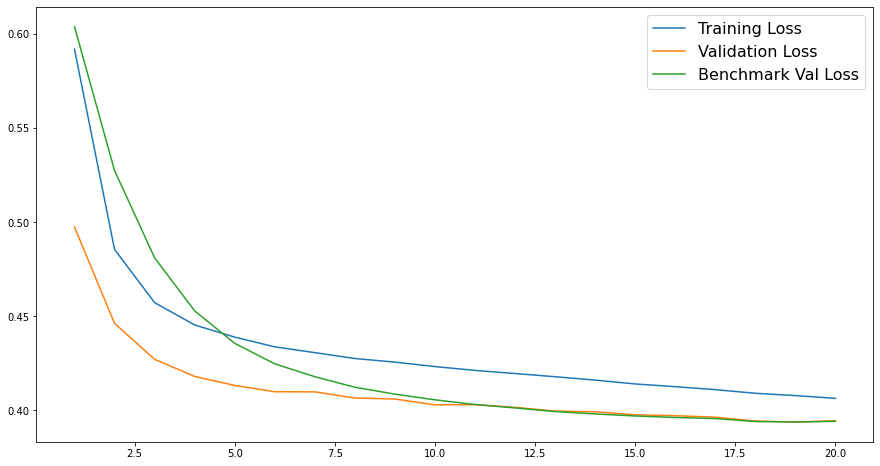

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16,
                                kernel_initializer='lecun_normal', 
                                activation='selu')(inputs)

dense_2 = tf.keras.layers.Dense(16, 
                                kernel_initializer='lecun_normal', 
                                activation='selu')(dense_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy'])

# Training
epochs = 20
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t))

# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,epochs+1), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

## Batch Normalization

In Tensorflow, the Batch Normalization `tf.keras.layers.BatchNormalization()` is considered as a layer of the network.<br>In order to be effective, **it should be placed after each hidden layer**.

In general, **it is recommended to apply the Batch Normalization layer before the activation function of the hidden layers**. Note that **it is also possible to apply the Batch Normalization method after the input layer**.

> <font color='grey'>*The reason for this is that the Batch Normalization layer performs normalization on the input data, which can cause the distribution of the input values to be shifted and scaled. If the activation function is applied before the Batch Normalization layer, the activation function may discard or modify the information provided by the Batch Normalization layer, leading to suboptimal performance.*

The Tensorflow implementation can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization).<br>It has several parameters (initialization, regularization ...) including a **`momentum` parameter that controls the exponential moving average decay rate** of the batch statistics.

> <font color='grey'>*During training, the mean and variance of the current batch are computed and used for normalization. These values are then combined with the running mean and variance using the momentum parameter to update the running statistics. <br>The running mean and variance are used for normalization during inference. By default, the momentum is set to 0.99, which means that 99% of the information from the previous running statistics is retained and 1% of the information from the current batch statistics is used to update them.*

**<font color='blue'>1.a.Re-build the network with the batch normalization method.<br>1.b. Show its summary.<br>1.c.Train it and compare the results with the Benchmark**

*Tips: Don't forget to use the activation of the hidden layer after the batch normalization.<br> You can use the tf.keras.layers.Activation() layer.*

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16,
                                kernel_initializer='he_normal', 
                                activation=None)(inputs)

bn_1 = tf.keras.layers.BatchNormalization()(dense_1)
act_1 = tf.keras.layers.Activation('relu')(bn_1)

dense_2 = tf.keras.layers.Dense(16, 
                                kernel_initializer='he_normal', 
                                activation=None)(act_1)

bn_2 = tf.keras.layers.BatchNormalization()(dense_2)
act_2 = tf.keras.layers.Activation('relu')(bn_2)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(act_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['Accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 16)                624       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                             

Epoch 1/20
279/279 [==============================] - 2s 4ms/step - loss: 0.6868 - Accuracy: 0.5753 - val_loss: 0.6267 - val_Accuracy: 0.6535
Epoch 2/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5974 - Accuracy: 0.6808 - val_loss: 0.5593 - val_Accuracy: 0.7001
Epoch 3/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5480 - Accuracy: 0.7282 - val_loss: 0.5187 - val_Accuracy: 0.7269
Epoch 4/20
279/279 [==============================] - 1s 3ms/step - loss: 0.5193 - Accuracy: 0.7447 - val_loss: 0.4877 - val_Accuracy: 0.7520
Epoch 5/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4972 - Accuracy: 0.7623 - val_loss: 0.4656 - val_Accuracy: 0.7771
Epoch 6/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4818 - Accuracy: 0.7725 - val_loss: 0.4479 - val_Accuracy: 0.7950
Epoch 7/20
279/279 [==============================] - 1s 3ms/step - loss: 0.4706 - Accuracy: 0.7809 - val_loss: 0.4353 - val_Accuracy: 0.7959
Epoch 

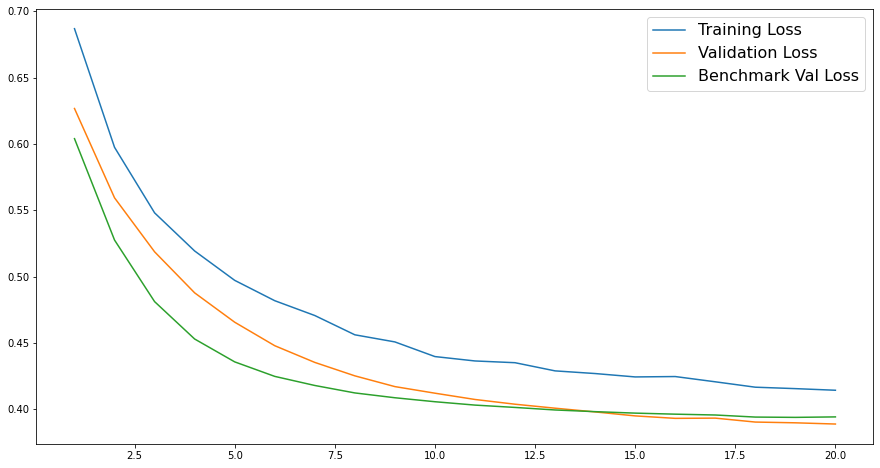

In [ ]:
# Training
epochs = 20
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t))

# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,epochs+1), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

## Gradient Clipping

In Tensorflow, Gradient Clipping involves computing the gradient "manually' with the `tf.clip_by_value()` function.<br> It will be done in an other Notebook.

# Overfitting tools

## Early Stopping

**In Tensorflow, Early stopping can be done using the callbacks.**

Callbacks are a powerful feature in TensorFlow that allow you to customize and control the training process of your model. Callbacks are objects that can be passed to the `fit()` method of a Keras model to be executed at various points during training, such as at the end of each epoch or after each batch. 

```
history = model.fit(...,
                    callbacks = [cb_1, ..., cb_n])
```

The Early Stopping callback can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).<br> Here are the most important parameters of the EarlyStopping callback:

* **monitor**: *This parameter specifies the metric to monitor during training. The callback will stop the training process when the monitored metric stops improving. For example, `monitor='val_loss'` will monitor the validation loss during training.*

* **patience**: *This parameter specifies the number of epochs to wait before stopping the training process when the monitored metric stops improving. For example, `patience=5` will wait for 5 epochs before stopping the training process if the monitored metric does not improve.*

* **mode**: *This parameter specifies whether the monitored metric should be maximized or minimized. For example, `mode='min'` will stop the training process when the validation loss stops decreasing.*

* **restore_best_weights**: *This parameter controls whether the weights of the model should be set to the best weights observed during training when the training process is stopped early. If `restore_best_weights=True`, the weights of the model will be set to the best weights, and the training process will be terminated. If `restore_best_weights=False`, the weights of the model at the end of the training process will be used.*

* **min_delta** & **baseline**: *These two parameters specifies the minimum improvement (`min_delta`) or threshold (`baseline`) of the monitored metric to stop the training process.  For example, the training will be stopped if the monitored metric is below the `treshold` or doesn't improve improve much than `min_delta`.*

A list of the other available builtin callbacks can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

**<font color='blue'>1.a.Create an Early Stopping callback with a `patience` parameter set to 3 and a `restore_best_weights` one set to True.**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

**<font color='blue'>1.b. Re-build the benchmark network and *Train it for 100 epochs with the Early Stopping method.<br> Display the learning curves and comment them.**

*Tips: Don't forget to add the early stopping callback when run the `fit()` !*

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16, activation='relu')(inputs)

dense_2 = tf.keras.layers.Dense(16, activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy'])

# Training
epochs = 100
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t),
                    callbacks=[early])

Epoch 1/100
279/279 [==============================] - 1s 3ms/step - loss: 0.6404 - Accuracy: 0.6520 - val_loss: 0.6039 - val_Accuracy: 0.6911
Epoch 2/100
279/279 [==============================] - 1s 3ms/step - loss: 0.5535 - Accuracy: 0.7388 - val_loss: 0.5275 - val_Accuracy: 0.7422
Epoch 3/100
279/279 [==============================] - 1s 3ms/step - loss: 0.4919 - Accuracy: 0.7731 - val_loss: 0.4811 - val_Accuracy: 0.7735
Epoch 4/100
279/279 [==============================] - 1s 3ms/step - loss: 0.4590 - Accuracy: 0.7908 - val_loss: 0.4529 - val_Accuracy: 0.7914
Epoch 5/100
279/279 [==============================] - 1s 3ms/step - loss: 0.4414 - Accuracy: 0.8025 - val_loss: 0.4357 - val_Accuracy: 0.7986
Epoch 6/100
279/279 [==============================] - 1s 3ms/step - loss: 0.4308 - Accuracy: 0.8094 - val_loss: 0.4248 - val_Accuracy: 0.8039
Epoch 7/100
279/279 [==============================] - 1s 3ms/step - loss: 0.4245 - Accuracy: 0.8128 - val_loss: 0.4180 - val_Accuracy: 0.8075

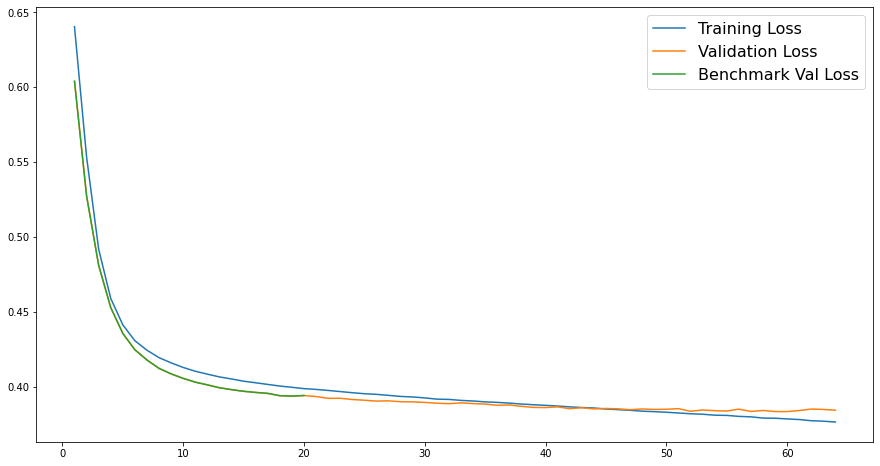

In [ ]:
# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,len(loss['loss'])+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,len(loss['loss'])+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,21), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

## Regularization

In Tensorflow, **Regularization is generally added directly in the layers** using one of the following parameter:

*   `kernel_regularizer`: *apply the regularization on both the neurons and the bias of the layer*
*   `bias_regularizer`: *apply the regularization on the bias of the layer*
*   `activity_regularizer`: *apply the regularization on the neurons of the layer*

You can find the available regularizations [here](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers). 

**<font color='blue'>Re-build the Benchmarck network with the a L1 & L2 regularization for the hidden layers.<br> Train it for 100 epochs and compare the results with the benchmark**

*Tips: The regularization effect can be very strong.<br>Start with very low values and increase if there is still some overfitting problems.*

Epoch 1/50
279/279 [==============================] - 2s 3ms/step - loss: 0.6602 - Accuracy: 0.6522 - val_loss: 0.6239 - val_Accuracy: 0.6911
Epoch 2/50
279/279 [==============================] - 1s 3ms/step - loss: 0.5736 - Accuracy: 0.7386 - val_loss: 0.5476 - val_Accuracy: 0.7422
Epoch 3/50
279/279 [==============================] - 1s 3ms/step - loss: 0.5121 - Accuracy: 0.7734 - val_loss: 0.5012 - val_Accuracy: 0.7744
Epoch 4/50
279/279 [==============================] - 1s 3ms/step - loss: 0.4791 - Accuracy: 0.7908 - val_loss: 0.4730 - val_Accuracy: 0.7914
Epoch 5/50
279/279 [==============================] - 1s 3ms/step - loss: 0.4614 - Accuracy: 0.8026 - val_loss: 0.4557 - val_Accuracy: 0.7986
Epoch 6/50
279/279 [==============================] - 1s 3ms/step - loss: 0.4508 - Accuracy: 0.8089 - val_loss: 0.4447 - val_Accuracy: 0.8057
Epoch 7/50
279/279 [==============================] - 1s 3ms/step - loss: 0.4444 - Accuracy: 0.8129 - val_loss: 0.4378 - val_Accuracy: 0.8075
Epoch 

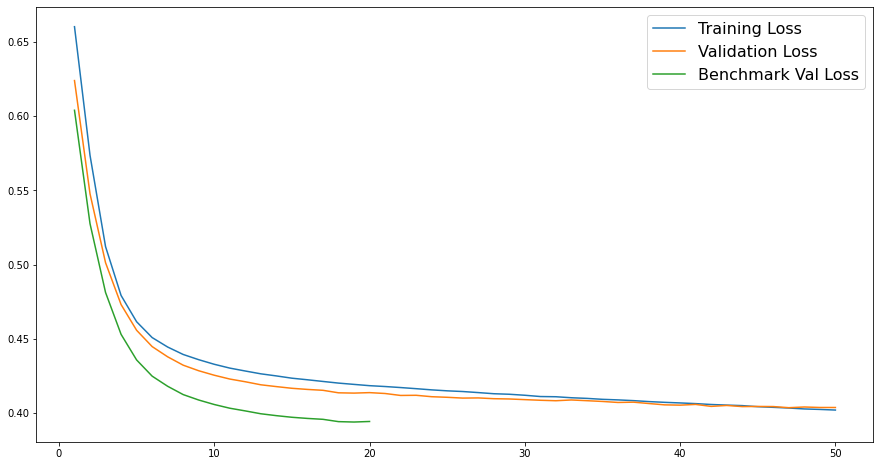

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

reg = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16,
                                kernel_regularizer=reg, 
                                activation='relu')(inputs)

dense_2 = tf.keras.layers.Dense(16, 
                                kernel_regularizer=reg, 
                                activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['Accuracy'])

# Training
epochs = 50
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t))

# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,21), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

## Dropout

In Tensorflow, the Dropout `tf.keras.layers.Dropout()` is considered as a layer of the network.<br>

The Tensorflow implementation can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout).<br> It has  two important parameters that can be used to control the behavior of the Dropout layer: rate and noise_shape.

* **rate**: *The `rate` parameter is a float value between 0 and 1 that specifies the dropout rate, or the fraction of the input units to drop during training. For example, a rate of 0.2 means that 20% of the input units will be randomly dropped out during each training step.*

* **noise_shape**: *The `noise_shape` parameter is an optional parameter that can be used to specify the shape of the binary dropout mask that is multiplied with the input. The `noise_shape` parameter should be a tuple of integers that represents the shape of the binary dropout mask, which should have the same shape as the input except for the dimensions that represent the batch size and the feature size.*

**<font color='blue'>1.a.Re-build the network with the dropout method.<br>1.b. Show its summary.<br>1.c.Train it for 50 epochs and compare the results with the Benchmark**

In [ ]:
tf.keras.backend.clear_session()
reset_seeds()

# Architecture
inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(16, activation='relu')(inputs)

drop_1 = tf.keras.layers.Dropout(0.2)(dense_1)

dense_2 = tf.keras.layers.Dense(16, activation='relu')(drop_1)

drop_2 = tf.keras.layers.Dropout(0.2)(dense_2)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(drop_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 16)                624       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 913
Trainable params: 913
Non-trainable params:

Epoch 1/50
279/279 [==============================] - 2s 3ms/step - loss: 0.6592 - Accuracy: 0.6032 - val_loss: 0.6189 - val_Accuracy: 0.6858
Epoch 2/50
279/279 [==============================] - 1s 3ms/step - loss: 0.6040 - Accuracy: 0.6717 - val_loss: 0.5578 - val_Accuracy: 0.7269
Epoch 3/50
279/279 [==============================] - 1s 3ms/step - loss: 0.5600 - Accuracy: 0.7137 - val_loss: 0.5146 - val_Accuracy: 0.7637
Epoch 4/50
279/279 [==============================] - 1s 3ms/step - loss: 0.5272 - Accuracy: 0.7396 - val_loss: 0.4838 - val_Accuracy: 0.7798
Epoch 5/50
279/279 [==============================] - 1s 3ms/step - loss: 0.5082 - Accuracy: 0.7563 - val_loss: 0.4627 - val_Accuracy: 0.7887
Epoch 6/50
279/279 [==============================] - 1s 3ms/step - loss: 0.4990 - Accuracy: 0.7622 - val_loss: 0.4484 - val_Accuracy: 0.7950
Epoch 7/50
279/279 [==============================] - 1s 3ms/step - loss: 0.4865 - Accuracy: 0.7704 - val_loss: 0.4386 - val_Accuracy: 0.7977
Epoch 

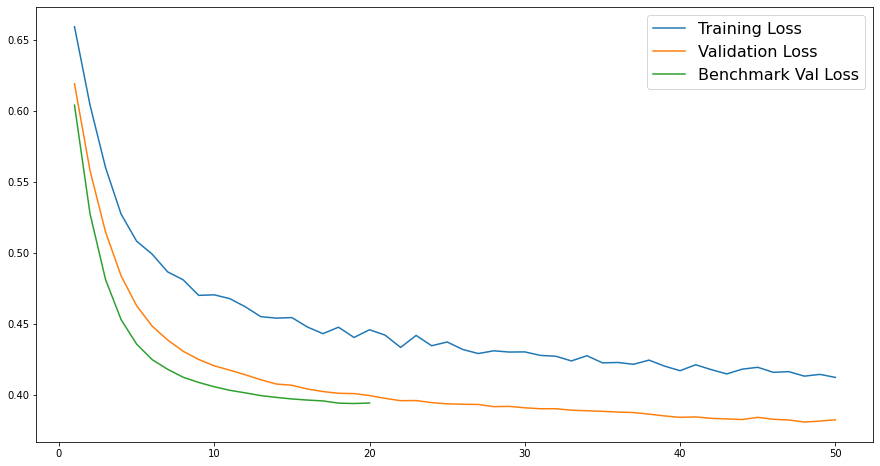

In [ ]:
# Training
epochs = 50
batch_size = 32
history = model.fit(X_train_t, y_train_t,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_t, y_val_t))

# Learning Curves
loss = history.history

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,epochs+1), loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), loss['val_loss'], label='Validation Loss')
plt.plot(np.arange(1,21), bench_loss['val_loss'], label='Benchmark Val Loss')

plt.legend(fontsize=16)
plt.show()

**<font color='blue'>2. What happened to the training loss ?**

In [ ]:
# The dropout is only active during the training steps and inactive during the testing/validation steps.
# Thus, the network is "incomplete" when calculating the loss during training
# resulting in a much lower loss.